In [7]:
from google.colab import drive
import pandas as pd
import os
import numpy as np
import re # Nécessaire pour nettoyer les AUs

# 1. Monter le Drive
drive.mount('/content/drive')

print("Google Drive monté avec succès.")

Mounted at /content/drive
Google Drive monté avec succès.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# --- CONFIGURATION DU CHEMIN ---

# COLLE LE CHEMIN ICI (garde les guillemets)
# Exemple : '/content/drive/MyDrive/MonProjet/RAF-CE_Annotation'
DATASET_PATH = '/content/drive/MyDrive/Colab Datasets'

# Vérification simple pour voir si le dossier existe
if os.path.exists(DATASET_PATH):
    print(f"Chemin trouvé : {DATASET_PATH}")
    print("Fichiers présents :", os.listdir(DATASET_PATH))
else:
    print(f"ATTENTION : Le chemin '{DATASET_PATH}' n'existe pas. Vérifie le chemin copier-coller.")

Chemin trouvé : /content/drive/MyDrive/Colab Datasets
Fichiers présents : ['WA_Fn-UseC_-Telco-Customer-Churn.csv', 'aligned.zip', 'distribution.txt', 'RAFAU_label.txt', 'RAFCE_partition.txt', 'RAFCE_emolabel.txt', 'RAFCE_AUlabel.txt', 'raf_ce_lora_model']


In [10]:
# 1. Mapping des Émotions Composées (RAF-CE)
emotion_map = {
    0: 'Happily surprised', 1: 'Happily disgusted', 2: 'Sadly fearful',
    3: 'Sadly angry', 4: 'Sadly surprised', 5: 'Sadly disgusted',
    6: 'Fearfully angry', 7: 'Fearfully surprised', 8: 'Fearfully disgusted',
    9: 'Angrily surprised', 10: 'Angrily disgusted', 11: 'Disgustedly surprised',
    12: 'Happily fearful', 13: 'Happily sad'
}

# 2. Mapping des Partitions
partition_map = { 0: 'Train', 1: 'Test', 2: 'Validation' }

# 3. Mapping des Action Units (AUs) - Basé sur Wikipédia
au_map_wikipedia = {
    0: 'Neutral face', 1: 'Inner brow raiser', 2: 'Outer brow raiser',
    4: 'Brow lowerer', 5: 'Upper lid raiser', 6: 'Cheek raiser',
    7: 'Lid tightener', 8: 'Lips toward each other', 9: 'Nose wrinkler',
    10: 'Upper lip raiser', 11: 'Nasolabial deepener', 12: 'Lip corner puller',
    13: 'Sharp lip puller', 14: 'Dimpler', 15: 'Lip corner depressor',
    16: 'Lower lip depressor', 17: 'Chin raiser', 18: 'Lip pucker',
    19: 'Tongue show', 20: 'Lip stretcher', 21: 'Neck tightener',
    22: 'Lip funneler', 23: 'Lip tightener', 24: 'Lip pressor',
    25: 'Lips part', 26: 'Jaw drop', 27: 'Mouth stretch', 28: 'Lip suck'
}

In [11]:
def decode_aus(au_string):
    """Convertit '1 2 4' en liste ['Inner brow raiser', ...]"""
    if not isinstance(au_string, str): return []
    decoded_names = []
    au_ids = re.findall(r'\d+', au_string) # Trouve les chiffres
    for au_id in au_ids:
        name = au_map_wikipedia.get(int(au_id), f"Unknown AU {au_id}")
        decoded_names.append(name)
    return decoded_names

def load_rafce_dataset(base_path):
    try:
        # Chargement Emotion
        path_emo = os.path.join(base_path, 'RAFCE_emolabel.txt')
        df_emo = pd.read_csv(path_emo, sep=r'\s+', header=None, names=['filename', 'emotion_id'])

        # Chargement Partition
        path_part = os.path.join(base_path, 'RAFCE_partition.txt')
        df_part = pd.read_csv(path_part, sep=r'\s+', header=None, names=['filename', 'partition_id'])

        # Chargement AU (Lecture ligne par ligne pour sécurité)
        path_au = os.path.join(base_path, 'RAFCE_AUlabel.txt')
        with open(path_au, 'r') as f:
            au_lines = f.readlines()

        au_data = []
        for line in au_lines:
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 2:
                au_data.append({'filename': parts[0], 'au_raw': parts[1]})
            else:
                au_data.append({'filename': parts[0], 'au_raw': ''})
        df_au = pd.DataFrame(au_data)

    except FileNotFoundError as e:
        print(f"ERREUR : Fichier introuvable. Vérifie le chemin dans la Cellule 2.\n{e}")
        return None

    # Fusion
    master_df = pd.merge(df_emo, df_part, on='filename')
    master_df = pd.merge(master_df, df_au, on='filename')

    # Application des Mappings
    master_df['emotion_label'] = master_df['emotion_id'].map(emotion_map)
    master_df['dataset_partition'] = master_df['partition_id'].map(partition_map)

    # Décodage des AUs (Nouveau !)
    master_df['au_names'] = master_df['au_raw'].apply(decode_aus)

    return master_df

In [12]:
# Lancer le chargement
df = load_rafce_dataset(DATASET_PATH)

if df is not None:
    # Nettoyage de l'affichage
    cols = ['filename', 'dataset_partition', 'emotion_label', 'au_names', 'au_raw']
    df = df[cols]

    print("✅ Données chargées avec succès !")
    print(f"Nombre total d'images : {len(df)}")

    print("\n--- Aperçu des 5 premières lignes ---")
    display(df.head())

    print("\n--- Répartition Train/Test ---")
    print(df['dataset_partition'].value_counts())

✅ Données chargées avec succès !
Nombre total d'images : 4549

--- Aperçu des 5 premières lignes ---


filename dataset_partition      emotion_label  \
0  0001.jpg             Train    Sadly disgusted   
1  0002.jpg        Validation    Sadly disgusted   
2  0003.jpg              Test  Angrily disgusted   
3  0004.jpg             Train        Sadly angry   
4  0005.jpg             Train  Angrily disgusted   

                                            au_names           au_raw  
0       [Inner brow raiser, Brow lowerer, Lips part]           1+4+25  
1  [Brow lowerer, Nose wrinkler, Lip corner pulle...  4+9+12+25+26+43  
2                   [Lip corner puller, Lip pressor]           L12+24  
3                                                 []             null  
4                                                 []             null


--- Répartition Train/Test ---
dataset_partition
Train         2709
Validation     931
Test           909
Name: count, dtype: int64


--- Répartition des classes (Émotions) ---


Nombre  Pourcentage (%)
emotion_label                                 
Angrily disgusted         977        21.477248
Sadly disgusted           835        18.355683
Happily surprised         676        14.860409
Fearfully surprised       603        13.255661
Happily disgusted         279         6.133216
Sadly angry               230         5.056056
Angrily surprised         210         4.616399
Fearfully angry           195         4.286656
Disgustedly surprised     177         3.890965
Sadly fearful             171         3.759068
Sadly surprised           120         2.637942
Fearfully disgusted        36         0.791383
Happily sad                29         0.637503
Happily fearful            11         0.241811


Classe majoritaire : 977 images
Classe minoritaire : 11 images
Ratio de déséquilibre : 1 pour 88.82

⚠️ CONCLUSION : Le dataset est DÉSÉQUILIBRÉ (Unbalanced).
Le modèle risque de favoriser les classes majoritaires.


/tmp/ipython-input-3531120350.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


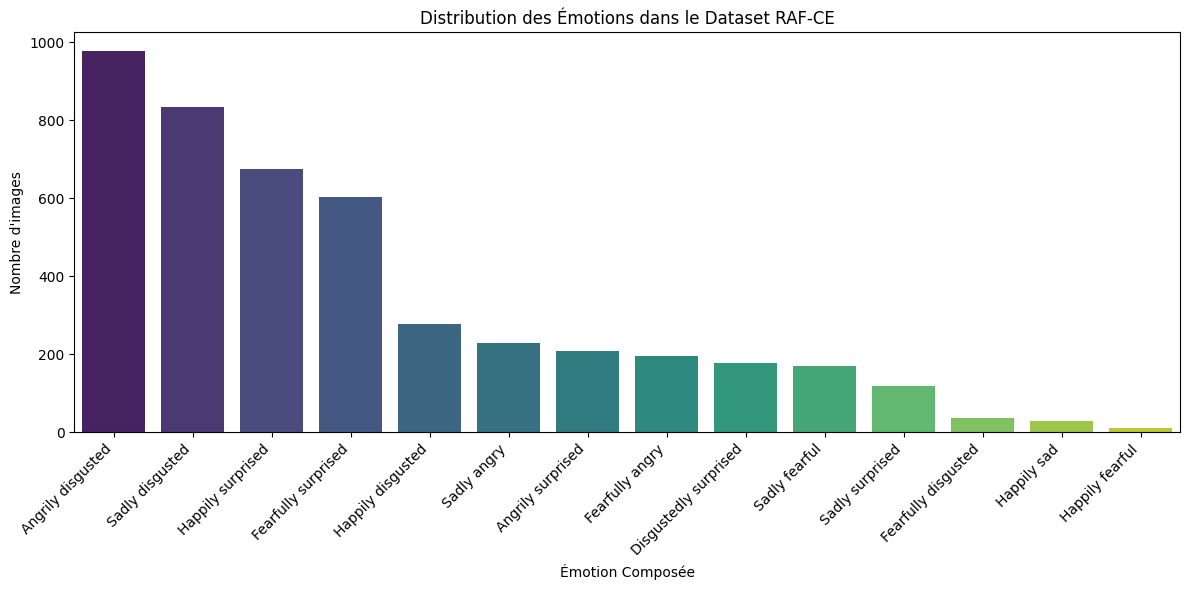

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_dataset_balance(dataframe):
    if dataframe is None:
        print("Erreur : Le DataFrame n'est pas chargé.")
        return

    # 1. Calculer les comptes et pourcentages
    counts = dataframe['emotion_label'].value_counts()
    percentages = dataframe['emotion_label'].value_counts(normalize=True) * 100

    # Créer un petit tableau récapitulatif
    balance_df = pd.DataFrame({'Nombre': counts, 'Pourcentage (%)': percentages})

    print("--- Répartition des classes (Émotions) ---")
    display(balance_df)

    # 2. Vérification mathématique du déséquilibre
    max_count = counts.max()
    min_count = counts.min()
    ratio = max_count / min_count

    print(f"\nClasse majoritaire : {max_count} images")
    print(f"Classe minoritaire : {min_count} images")
    print(f"Ratio de déséquilibre : 1 pour {ratio:.2f}")

    if ratio > 2.0:
        print("\n⚠️ CONCLUSION : Le dataset est DÉSÉQUILIBRÉ (Unbalanced).")
        print("Le modèle risque de favoriser les classes majoritaires.")
    else:
        print("\n✅ CONCLUSION : Le dataset est plutôt ÉQUILIBRÉ (Balanced).")

    # 3. Visualisation Graphique
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.index, y=counts.values, palette='viridis')
    plt.title('Distribution des Émotions dans le Dataset RAF-CE')
    plt.xlabel('Émotion Composée')
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45, ha='right') # Rotation des étiquettes pour lisibilité
    plt.tight_layout()
    plt.show()

# Exécuter la vérification
check_dataset_balance(df)

--- Répartition DÉTAILLÉE (Train / Test / Validation) ---


dataset_partition      Test  Train  Validation  Total
emotion_label                                        
Angrily disgusted       194    582         201    977
Sadly disgusted         178    495         162    835
Happily surprised       126    394         156    676
Fearfully surprised     113    352         138    603
Happily disgusted        54    171          54    279
Sadly angry              44    136          50    230
Angrily surprised        44    124          42    210
Fearfully angry          43    120          32    195
Disgustedly surprised    37    108          32    177
Sadly fearful            36    109          26    171
Sadly surprised          25     71          24    120
Fearfully disgusted       6     24           6     36
Happily sad               8     17           4     29
Happily fearful           1      6           4     11

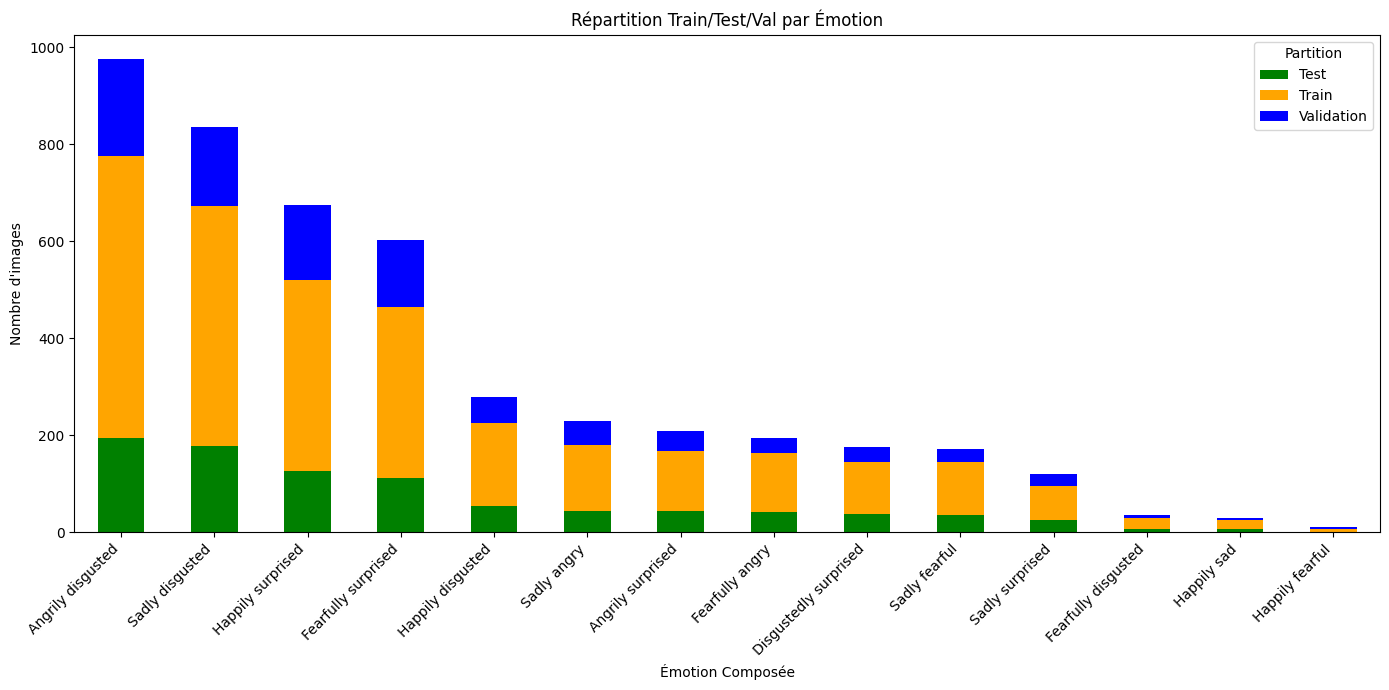


--- Recalcul des Poids pour l'entraînement ---
ID    | Émotion                   | Poids (Weight)
---------------------------------------------
0     | Happily surprised         | 0.4911
1     | Happily disgusted         | 1.1316
2     | Sadly fearful             | 1.7752
3     | Sadly angry               | 1.4228
4     | Sadly surprised           | 2.7254
5     | Sadly disgusted           | 0.3909
6     | Fearfully angry           | 1.6125
7     | Fearfully surprised       | 0.5497
8     | Fearfully disgusted       | 8.0625
9     | Angrily surprised         | 1.5605
10    | Angrily disgusted         | 0.3325
11    | Disgustedly surprised     | 1.7917
12    | Happily fearful           | 32.2500
13    | Happily sad               | 11.3824


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np

# --- ÉTAPE 1 : RÉPARATION (Fix du KeyError) ---
# On recrée la colonne 'emotion_id' à partir des noms, au cas où elle manque
name_to_id = {v: k for k, v in emotion_map.items()} # Inversion du dictionnaire
if 'emotion_id' not in df.columns:
    df['emotion_id'] = df['emotion_label'].map(name_to_id)

# --- ÉTAPE 2 : TABLEAU DE RÉPARTITION COMPLET ---
# On utilise un 'crosstab' pour croiser les Émotions avec les Partitions
distribution_table = pd.crosstab(df['emotion_label'], df['dataset_partition'])

# On ajoute une colonne 'Total' pour trier
distribution_table['Total'] = distribution_table.sum(axis=1)

# On trie du plus fréquent au moins fréquent
distribution_table = distribution_table.sort_values('Total', ascending=False)

print("--- Répartition DÉTAILLÉE (Train / Test / Validation) ---")
display(distribution_table)

# --- ÉTAPE 3 : VISUALISATION GRAPHIQUE ---
# On retire la colonne total pour le graphique pour ne pas fausser l'échelle
viz_data = distribution_table.drop(columns=['Total'])
viz_data.plot(kind='bar', stacked=True, figsize=(14, 7), color=['green', 'orange', 'blue'])
plt.title("Répartition Train/Test/Val par Émotion")
plt.ylabel("Nombre d'images")
plt.xlabel("Émotion Composée")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Partition')
plt.tight_layout()
plt.show()

# --- ÉTAPE 4 : CALCUL DES POIDS (Class Weights) CORRIGÉ ---
print("\n--- Recalcul des Poids pour l'entraînement ---")
df_train = df[df['dataset_partition'] == 'Train']
y_train = df_train['emotion_id'].values

# Vérification qu'on a bien des données
if len(y_train) > 0:
    classes_present = np.unique(y_train)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes_present,
        y=y_train
    )

    class_weights_dict = dict(zip(classes_present, weights))

    # Affichage propre
    print(f"{'ID':<5} | {'Émotion':<25} | {'Poids (Weight)':<10}")
    print("-" * 45)
    for emo_id in sorted(class_weights_dict.keys()):
        label = emotion_map[emo_id]
        weight = class_weights_dict[emo_id]
        print(f"{emo_id:<5} | {label:<25} | {weight:.4f}")
else:
    print("Erreur : Aucune donnée d'entraînement trouvée.")

In [15]:
import os
import cv2
import matplotlib.pyplot as plt

def verify_images_link(dataframe, folder_path):
    print(f"🔍 Vérification dans le dossier : {folder_path}")

    found = 0
    missing = 0

    # On prend un échantillon de 5 images pour tester
    sample_files = dataframe['filename'].head(5).values

    plt.figure(figsize=(15, 5))

    for i, filename in enumerate(sample_files):
        # --- MODIFICATION ICI ---
        # 1. On nettoie le nom venant du fichier texte (on enlève .jpg s'il est là)
        base_name = filename.replace('.jpg', '').replace('.jpeg', '').strip()

        # 2. On reconstruit le nom tel qu'il est sur le disque
        # Transformation : "train_0001" -> "train_0001_aligned.jpg"
        aligned_filename = f"{base_name}_aligned.jpg"

        # 3. Chemin complet
        full_path = os.path.join(folder_path, aligned_filename)
        # ------------------------

        if os.path.exists(full_path):
            found += 1
            # Lecture et affichage
            try:
                img = cv2.imread(full_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.subplot(1, 5, i+1)
                    plt.imshow(img)
                    plt.title(base_name) # On affiche le nom court
                    plt.axis('off')
                else:
                    print(f"⚠️ Image trouvée mais illisible : {aligned_filename}")
            except Exception as e:
                print(f"Erreur de lecture : {e}")
        else:
            missing += 1
            print(f"❌ Manquant : {aligned_filename} (Cherché à : {full_path})")

    plt.show()

    if missing == 0:
        print(f"\n✅ SUCCÈS TOTAL : 5/5 images trouvées !")
        print("La logique de nommage (ajout de '_aligned') fonctionne.")
    else:
        print(f"\n⚠️ PROBLÈME : {missing} images manquantes.")
        print("Vérifie si le dossier contient bien des fichiers finissant par '_aligned.jpg'")

# Lancer la vérification avec le dossier décompressé
# Assure-toi que FINAL_IMAGE_PATH est bien défini (suite à la décompression précédente)
if 'FINAL_IMAGE_PATH' in locals():
    verify_images_link(df, FINAL_IMAGE_PATH)
else:
    print("La variable FINAL_IMAGE_PATH n'existe pas. Relance la cellule de décompression (Unzip).")

La variable FINAL_IMAGE_PATH n'existe pas. Relance la cellule de décompression (Unzip).


📂 Décompression de '/content/drive/MyDrive/Colab Datasets/aligned.zip' en cours...
Cela peut prendre quelques secondes/minutes selon la taille...
✅ Décompression terminée avec succès !

Contenu du dossier extrait : ['aligned']
👉 Chemin final des images configuré sur : /content/rafce_images_unzipped/aligned
🔍 Vérification dans le dossier : /content/rafce_images_unzipped/aligned


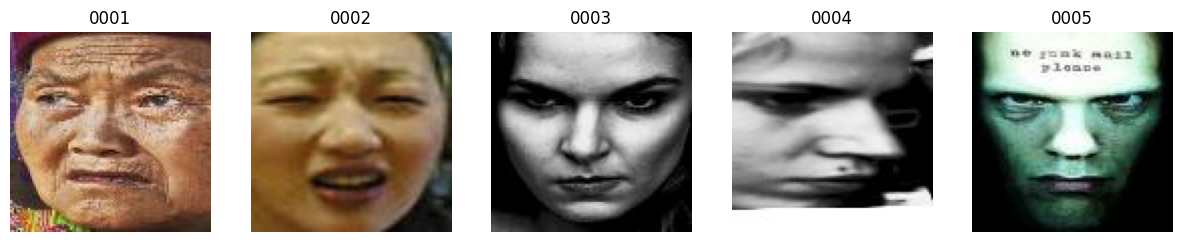


✅ SUCCÈS TOTAL : 5/5 images trouvées !
La logique de nommage (ajout de '_aligned') fonctionne.


In [16]:
import zipfile
import os

# 1. Définition des chemins
zip_path = '/content/drive/MyDrive/Colab Datasets/aligned.zip'
local_extract_path = '/content/rafce_images_unzipped' # Dossier local rapide

# 2. Décompression (Unzip)
if not os.path.exists(local_extract_path):
    print(f"📂 Décompression de '{zip_path}' en cours...")
    print("Cela peut prendre quelques secondes/minutes selon la taille...")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(local_extract_path)
        print("✅ Décompression terminée avec succès !")
    except FileNotFoundError:
        print("❌ ERREUR : Le fichier zip est introuvable au chemin indiqué.")
else:
    print("⚡ Le dossier existe déjà, on passe la décompression.")

# 3. Trouver le vrai dossier des images
# Parfois le zip contient un sous-dossier (ex: 'aligned/image.jpg')
# On regarde ce qu'il y a dedans
contents = os.listdir(local_extract_path)
print(f"\nContenu du dossier extrait : {contents}")

# Déterminer le bon chemin final
# Si le zip contient un dossier 'aligned', on rentre dedans. Sinon on reste à la racine.
if 'aligned' in contents and os.path.isdir(os.path.join(local_extract_path, 'aligned')):
    FINAL_IMAGE_PATH = os.path.join(local_extract_path, 'aligned')
else:
    # Si les images sont en vrac ou dans un autre dossier, on prend la racine
    # (Tu pourras ajuster ici selon ce que le print affiche)
    FINAL_IMAGE_PATH = local_extract_path

print(f"👉 Chemin final des images configuré sur : {FINAL_IMAGE_PATH}")

# 4. Relancer la vérification visuelle avec le nouveau chemin
# On réutilise la fonction verify_images_link définie juste avant
try:
    verify_images_link(df, FINAL_IMAGE_PATH)
except NameError:
    print("La fonction verify_images_link n'est pas définie. Relance la cellule précédente.")

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# 1. Définition des Transformations (Prétraitement)
# Les modèles comme ResNet attendent généralement du 224x224
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224)),      # Redimensionner
        transforms.RandomHorizontalFlip(),  # Augmentation : retourner l'image (miroir)
        transforms.RandomRotation(10),      # Augmentation : légère rotation
        transforms.ToTensor(),              # Convertir en Tensor (0-1)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation standard ImageNet
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 2. La Classe Dataset Personnalisée
class RAFCEDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Le tableau contenant les noms de fichiers et labels.
            root_dir (string): Le dossier contenant les images dézippées.
            transform (callable, optional): Les transformations à appliquer.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

        # On crée un mapping inverse pour convertir les labels (0, 1...) en Tensors
        # Assure-toi que la colonne 'emotion_id' existe (on l'a créée plus tôt)
        self.labels = self.dataframe['emotion_id'].values
        self.filenames = self.dataframe['filename'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 1. Récupérer le nom de base
        img_name = self.filenames[idx]

        # 2. Gérer le suffixe "_aligned" comme on l'a validé ensemble
        base_name = img_name.replace('.jpg', '').replace('.jpeg', '').strip()
        full_img_name = f"{base_name}_aligned.jpg"
        img_path = os.path.join(self.root_dir, full_img_name)

        # 3. Charger l'image
        try:
            image = Image.open(img_path).convert('RGB')
        except (IOError, FileNotFoundError):
            # Si une image est corrompue, on crée une image noire pour ne pas planter l'entraînement
            print(f"⚠️ Erreur chargement: {img_path}. Utilisation image noire.")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # 4. Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        # 5. Récupérer le label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, label

print("Classe RAFCEDataset définie avec succès.")

Classe RAFCEDataset définie avec succès.


In [18]:
# --- ÉTAPE 1 : RÉPARATION DU TABLEAU (Fix KeyError) ---
# On s'assure que la colonne 'emotion_id' existe bien avant de continuer
# On inverse le dictionnaire pour retrouver l'ID à partir du nom
name_to_id = {v: k for k, v in emotion_map.items()}

if 'emotion_id' not in df.columns:
    print("🔧 Colonne 'emotion_id' manquante. Réparation en cours...")
    df['emotion_id'] = df['emotion_label'].map(name_to_id)
else:
    print("✅ La colonne 'emotion_id' est bien présente.")

# --- ÉTAPE 2 : SÉPARATION DU DATAFRAME ---
# On utilise .copy() pour éviter des avertissements de Pandas
df_train = df[df['dataset_partition'] == 'Train'].copy()
df_test = df[df['dataset_partition'] == 'Test'].copy()
df_val = df[df['dataset_partition'] == 'Validation'].copy()

print("-" * 30)
print(f"Images Train: {len(df_train)}")
print(f"Images Test:  {len(df_test)}")
print(f"Images Val:   {len(df_val)}")
print("-" * 30)

# --- ÉTAPE 3 : CRÉATION DES CHARGEURS (DataLoaders) ---
BATCH_SIZE = 32

# Création des Datasets
train_dataset = RAFCEDataset(df_train, FINAL_IMAGE_PATH, transform=data_transforms['Train'])
test_dataset = RAFCEDataset(df_test, FINAL_IMAGE_PATH, transform=data_transforms['Test'])
val_dataset = RAFCEDataset(df_val, FINAL_IMAGE_PATH, transform=data_transforms['Validation'])

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders prêts et chargés !")

# Test final pour vérifier que les Tensors sortent bien
try:
    images, labels = next(iter(train_loader))
    print(f"Succès ! Forme d'un batch d'images : {images.shape}") # Doit afficher [32, 3, 224, 224]
    print(f"Succès ! Forme d'un batch de labels : {labels.shape}")
except Exception as e:
    print(f"❌ Erreur lors du chargement du batch : {e}")

✅ La colonne 'emotion_id' est bien présente.
------------------------------
Images Train: 2709
Images Test:  909
Images Val:   931
------------------------------
✅ DataLoaders prêts et chargés !
Succès ! Forme d'un batch d'images : torch.Size([32, 3, 224, 224])
Succès ! Forme d'un batch de labels : torch.Size([32])


In [19]:
import torch.nn as nn
from torchvision import models

# 1. Configuration du Matériel (GPU)
# Si tu as activé le T4, 'cuda' sera utilisé. Sinon 'cpu'.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"🧠 Le modèle sera entraîné sur : {device}")

# 2. Télécharger le modèle pré-entraîné (ResNet18)
print("Chargement de ResNet18...")
model = models.resnet18(weights='IMAGENET1K_V1')

# 3. Modifier la dernière couche (Fully Connected - fc)
# ResNet original a 1000 sorties. Nous en voulons 14.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 14) # 14 classes

# Envoyer le modèle sur le GPU
model = model.to(device)

# 4. Configuration de la Loss Function avec les POIDS (Class Weights)
# Rappel : Nous avons un dictionnaire 'class_weights_dict'.
# Nous devons le transformer en Tensor trié (de 0 à 13) pour PyTorch.

# On s'assure que les poids sont dans le bon ordre (0, 1, 2... 13)
weights_list = []
# Note : Si la variable class_weights_dict n'existe plus, on met des poids par défaut (1.0)
if 'class_weights_dict' in locals():
    print("✅ Utilisation des poids calculés pour le déséquilibre.")
    for i in range(14):
        weights_list.append(class_weights_dict.get(i, 1.0)) # 1.0 par défaut si erreur
else:
    print("⚠️ Attention : Poids introuvables. Utilisation de poids neutres.")
    weights_list = [1.0] * 14

# Conversion en Tensor PyTorch et envoi sur le GPU
class_weights_tensor = torch.FloatTensor(weights_list).to(device)

# La fonction de perte (Loss) qui guidera l'apprentissage
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 5. L'Optimiseur (Celui qui ajuste les neurones)
# Adam est un excellent choix standard. Learning rate bas (0.0001) pour ne pas tout casser.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print("\n🚀 Modèle prêt à l'emploi !")
print(f"Structure de la dernière couche : {model.fc}")

🧠 Le modèle sera entraîné sur : cuda:0
Chargement de ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


✅ Utilisation des poids calculés pour le déséquilibre.

🚀 Modèle prêt à l'emploi !
Structure de la dernière couche : Linear(in_features=512, out_features=14, bias=True)


In [23]:

#############################################################
##########################################################
############# RESNET 3 EPOCH ACCURACY ~~33%    resultat louta############




import time
import copy
import sys

def train_model(model, criterion, optimizer, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # On utilise enumerate pour savoir où on en est (i = numéro du batch)
            for i, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # --- NOUVEAU : Affichage de progression ---
                # Affiche un message tous les 10 batchs (environ toutes les 320 images)
                if i % 10 == 0:
                    # \r permet d'écraser la ligne précédente pour faire propre
                    sys.stdout.write(f'\rPhase: {phase} | Batch {i}/{len(dataloader)} | Loss en cours: {loss.item():.4f}')
                    sys.stdout.flush()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'\n✅ Fin {phase} : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print("🌟 Nouveau record ! Modèle sauvegardé.")

    time_elapsed = time.time() - since
    print(f'\nEntraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure Accuracy (Validation): {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- RELANCER ---
print("Lancement de l'entraînement avec affichage détaillé...")
trained_model, history = train_model(model, criterion, optimizer, num_epochs=3)

Lancement de l'entraînement avec affichage détaillé...

Epoch 1/3
----------
Phase: Train | Batch 80/85 | Loss en cours: 1.9473
✅ Fin Train : Loss: 2.3014 Acc: 0.2492
Phase: Validation | Batch 20/30 | Loss en cours: 2.2841
✅ Fin Validation : Loss: 2.3303 Acc: 0.2707
🌟 Nouveau record ! Modèle sauvegardé.

Epoch 2/3
----------
Phase: Train | Batch 80/85 | Loss en cours: 1.8648
✅ Fin Train : Loss: 1.8433 Acc: 0.3636
Phase: Validation | Batch 20/30 | Loss en cours: 2.2066
✅ Fin Validation : Loss: 2.2477 Acc: 0.2975
🌟 Nouveau record ! Modèle sauvegardé.

Epoch 3/3
----------
Phase: Train | Batch 80/85 | Loss en cours: 1.4282
✅ Fin Train : Loss: 1.4365 Acc: 0.4655
Phase: Validation | Batch 20/30 | Loss en cours: 2.0404
✅ Fin Validation : Loss: 2.2513 Acc: 0.3383
🌟 Nouveau record ! Modèle sauvegardé.

Entraînement terminé en 43m 19s
Meilleure Accuracy (Validation): 0.3383


In [1]:
#####################################################################
#######################################################################
##############   RESNET 50 EPOCH BECH NKHADMO LILA#####################
import time
import copy
import sys
import torch

def train_night_mode(model, criterion, optimizer, num_epochs=50):
    since = time.time()

    # On garde une copie en mémoire RAM
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"🚀 Démarrage de l'entraînement de nuit pour {num_epochs} époques...")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Boucle sur les batchs
            for i, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Affichage de progression fluide
                if i % 10 == 0:
                    sys.stdout.write(f'\rPhase: {phase} | Batch {i}/{len(dataloader)} | Loss: {loss.item():.4f}')
                    sys.stdout.flush()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'\n✅ Fin {phase} : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Historique
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # --- SAUVEGARDE DU MEILLEUR MODÈLE (Sur le Disque) ---
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Sauvegarde physique immédiate
                torch.save(model.state_dict(), 'best_model_night.pth')
                print(f"🌟 Record battu ({best_acc:.4f}) ! Sauvegardé dans 'best_model_night.pth'")

        # --- SAUVEGARDE DE SÉCURITÉ (Checkpoint) ---
        # Toutes les 10 époques, on fait une sauvegarde au cas où
        if (epoch + 1) % 10 == 0:
            ckpt_name = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), ckpt_name)
            print(f"💾 Checkpoint de sécurité créé : {ckpt_name}")

    time_elapsed = time.time() - since
    print(f'\n🌙 Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure Accuracy Finale: {best_acc:.4f}')

    # On charge les meilleurs poids pour finir
    model.load_state_dict(best_model_wts)
    return model, history

# --- LANCEMENT ---
# Assure-toi que 'model', 'criterion' et 'optimizer' sont définis dans les cellules d'avant
trained_model, history = train_night_mode(model, criterion, optimizer, num_epochs=50)

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Fonction pour obtenir toutes les prédictions du Test Set
def get_all_predictions(model, loader):
    model.eval() # Mode évaluation
    all_preds = []
    all_labels = []

    print("🔮 Calcul des prédictions sur le jeu de Test... (Patientez)")

    with torch.no_grad(): # Pas besoin de calcul de gradient (économie mémoire)
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# 2. Récupérer les noms des classes (pour l'affichage)
# On reconstruit le dictionnaire ID -> Nom
id_to_name = {v: k for k, v in name_to_id.items()}
class_names = [id_to_name[i] for i in range(14)]

# 3. Lancer les prédictions
y_pred, y_true = get_all_predictions(trained_model, test_loader)

# 4. Afficher la Matrice de Confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)

# Création de la carte thermique (Heatmap)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Prédiction du Modèle')
plt.ylabel('Vraie Émotion')
plt.title('Matrice de Confusion (Où le modèle se trompe-t-il ?)')
plt.xticks(rotation=45, ha='right')
plt.show()

# 5. Afficher le rapport détaillé (Précision par classe)
print("\n--- RAPPORT DÉTAILLÉ PAR ÉMOTION ---")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

🎲 Test sur 3 images au hasard du jeu de Test :


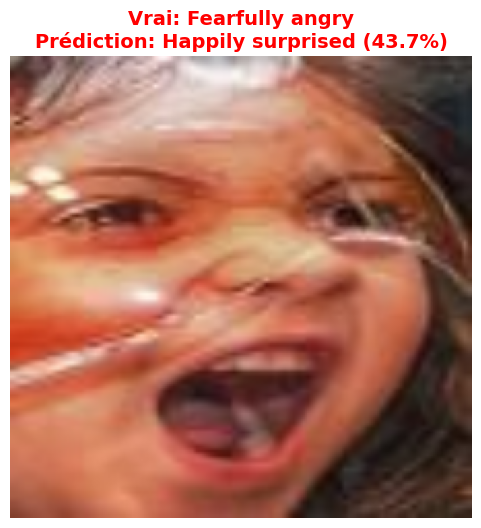

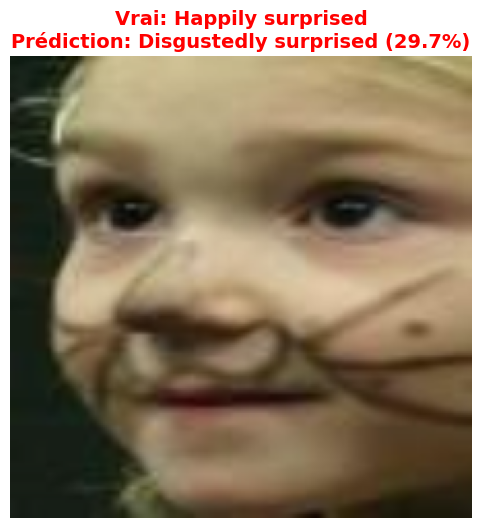

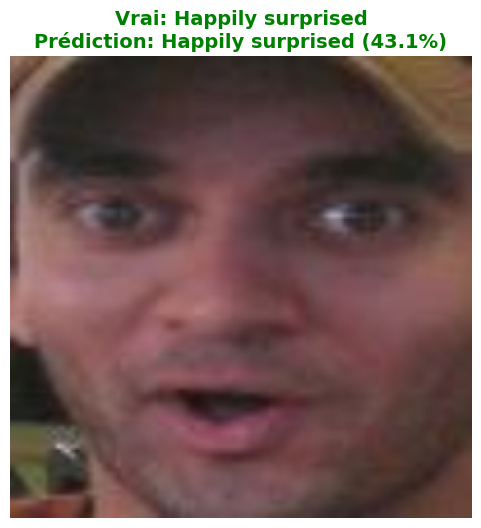

In [36]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. Fonction pour faire une prédiction sur une seule image
def predict_random_image(dataset, model):
    # Choisir un index au hasard
    idx = random.randint(0, len(dataset) - 1)

    # Récupérer l'image et le vrai label
    image_tensor, label_idx = dataset[idx]

    # Préparer l'image pour l'affichage (dé-normalisation pour qu'elle soit jolie)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_display = inv_normalize(image_tensor)
    image_display = image_display.permute(1, 2, 0).numpy()
    image_display = np.clip(image_display, 0, 1) # S'assurer que les pixels sont entre 0 et 1

    # --- PRÉDICTION ---
    model.eval()
    # Ajouter une dimension de batch (1, 3, 224, 224) car le modèle attend un lot
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        # Calculer les probabilités (Softmax)
        probs = F.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, 1)

    # Récupérer les noms
    true_emotion = id_to_name[label_idx.item()]
    pred_emotion = id_to_name[pred_idx.item()]
    conf_score = confidence.item() * 100

    # --- AFFICHAGE ---
    plt.figure(figsize=(6, 6))
    plt.imshow(image_display)
    plt.axis('off')

    # Couleur du titre : Vert si correct, Rouge si erreur
    title_color = 'green' if true_emotion == pred_emotion else 'red'

    plt.title(f"Vrai: {true_emotion}\nPrédiction: {pred_emotion} ({conf_score:.1f}%)",
              color=title_color, fontsize=14, fontweight='bold')
    plt.show()

# 2. Lancer le test plusieurs fois
print("🎲 Test sur 3 images au hasard du jeu de Test :")
predict_random_image(test_dataset, trained_model)
predict_random_image(test_dataset, trained_model)
predict_random_image(test_dataset, trained_model)

🎲 Test Final (Version corrigée) :


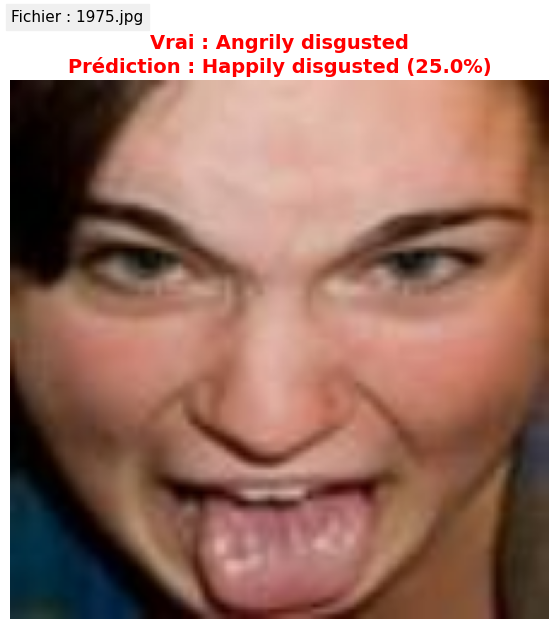

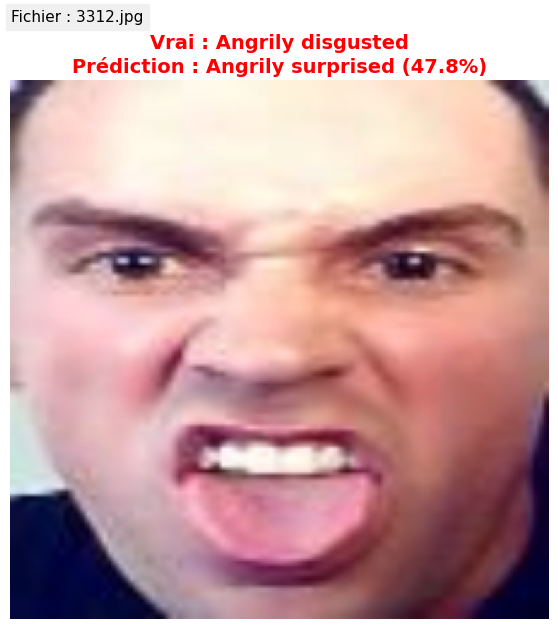

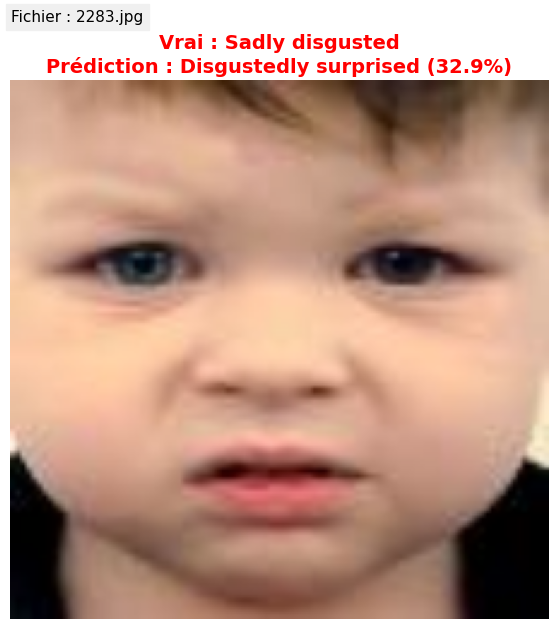

In [51]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms

# --- 1. DÉFINITION EN DUR DE LA LISTE DES ÉMOTIONS ---
# On s'assure que l'ordre est le même que celui utilisé lors de l'entraînement
# (Basé sur votre rapport de classification précédent)
LABELS_LIST = [
    'Happily surprised', 'Happily disgusted', 'Sadly fearful', 'Sadly angry',
    'Sadly surprised', 'Sadly disgusted', 'Fearfully angry', 'Fearfully surprised',
    'Fearfully disgusted', 'Angrily surprised', 'Angrily disgusted',
    'Disgustedly surprised', 'Happily fearful', 'Happily sad'
]

def predict_random_image_final(dataset, model):
    # Choisir un index au hasard
    idx = random.randint(0, len(dataset) - 1)

    # Récupérer l'image, le label ID et le nom du fichier
    image_tensor, label_idx = dataset[idx]
    filename = dataset.filenames[idx]

    # Préparation pour affichage
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_display = inv_normalize(image_tensor)
    image_display = image_display.permute(1, 2, 0).numpy()
    image_display = np.clip(image_display, 0, 1)

    # --- PRÉDICTION ---
    model.eval()
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, 1)

    # --- TRADUCTION ID -> TEXTE ---
    # On utilise la liste définie au début de la cellule
    try:
        true_emotion = LABELS_LIST[label_idx.item()]
        pred_emotion = LABELS_LIST[pred_idx.item()]
    except IndexError:
        true_emotion = f"ID inconnu ({label_idx.item()})"
        pred_emotion = f"ID inconnu ({pred_idx.item()})"

    conf_score = confidence.item() * 100

    # --- AFFICHAGE ---
    plt.figure(figsize=(7, 7))
    plt.imshow(image_display)
    plt.axis('off')

    color = 'green' if true_emotion == pred_emotion else 'red'

    # Affichage du nom de fichier pour vérification manuelle
    plt.text(0, -25, f"Fichier : {filename}", fontsize=11,
             backgroundcolor='#f0f0f0', color='black')

    plt.title(f"Vrai : {true_emotion}\nPrédiction : {pred_emotion} ({conf_score:.1f}%)",
              color=color, fontsize=14, fontweight='bold')
    plt.show()

# --- LANCER LE TEST ---
print("🎲 Test Final (Version corrigée) :")
predict_random_image_final(test_dataset, trained_model)
predict_random_image_final(test_dataset, trained_model)
predict_random_image_final(test_dataset, trained_model)

In [52]:
import torch
from google.colab import files

# 1. Sauvegarder les poids du modèle dans Colab
model_save_name = 'emotion_resnet18_cpu.pth'
path = F"/content/{model_save_name}"
torch.save(trained_model.state_dict(), path)
print(f"✅ Modèle sauvegardé temporairement sous : {path}")

# 2. Télécharger le fichier sur ton ordinateur
print("📥 Téléchargement en cours...")
files.download(path)

✅ Modèle sauvegardé temporairement sous : /content/emotion_resnet18_cpu.pth
📥 Téléchargement en cours...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📸 Envoie une image (JPG/PNG) pour tester l'IA :


Saving Screenshot 2025-12-28 113646.png to Screenshot 2025-12-28 113646.png


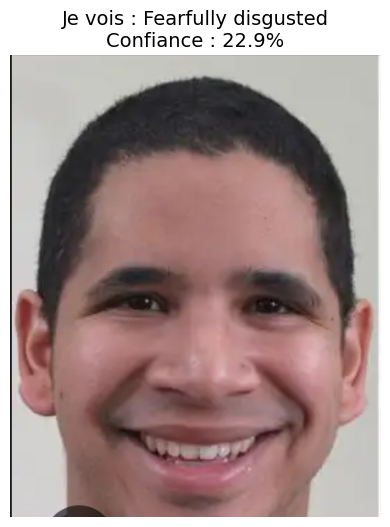

In [61]:
from google.colab import files
from PIL import Image
import io

# 1. Fonction de prédiction sur une image externe
def predict_external_image(model):
    print("📸 Envoie une image (JPG/PNG) pour tester l'IA :")
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Charger l'image
        image_data = uploaded[fn]
        image = Image.open(io.BytesIO(image_data)).convert('RGB')

        # Transformer l'image (Même transformation que pour l'entraînement)
        # Redimensionner en 224x224 est CRUCIAL
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image_tensor = transform(image).unsqueeze(0).to(device)

        # Prédiction
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, pred_idx = torch.max(probs, 1)

        pred_label = LABELS_LIST[pred_idx.item()]

        # Affichage
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Je vois : {pred_label}\nConfiance : {confidence.item()*100:.1f}%", fontsize=14)
        plt.show()

# 2. Lancer
predict_external_image(trained_model)

In [ ]:
import os

def train_model_with_checkpoints(model, criterion, optimizer, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'✅ {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Enregistrement historique
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Sauvegarde du meilleur modèle
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # --- SÉCURITÉ : SAUVEGARDE INTERMÉDIAIRE TOUTES LES 5 ÉPOQUES ---
        if (epoch + 1) % 5 == 0:
            ckpt_name = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), ckpt_name)
            print(f"💾 Sauvegarde de sécurité effectuée : {ckpt_name}")

    time_elapsed = time.time() - since
    print(f'\nEntraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure Accuracy: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# Lancer la nuit
# trained_model, history = train_model_with_checkpoints(model, criterion, optimizer, num_epochs=50)

In [62]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=a2638946a2c116eea670857280846036d5b4873dcf8ae18380b5a19233bc6a00
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


🕵️ Analyse XAI en cours...


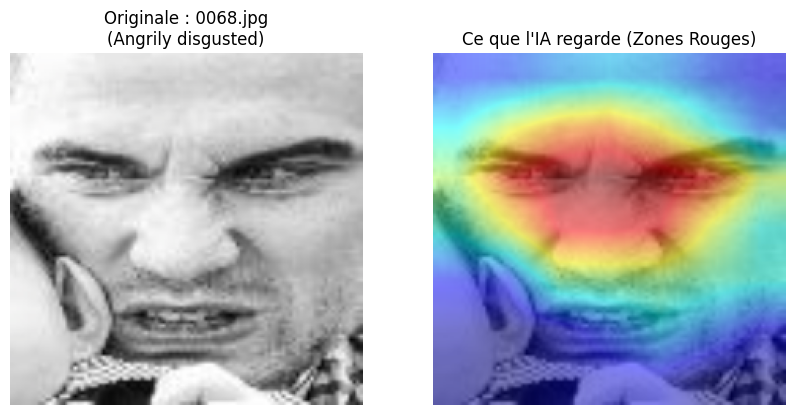

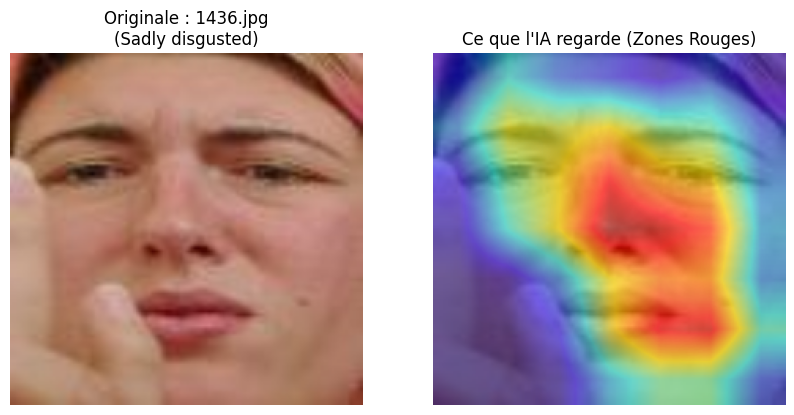

In [65]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

# 1. Configuration de Grad-CAM pour ResNet
# ResNet est composé de 4 blocs principaux (layer1, layer2, layer3, layer4).
# On regarde généralement la dernière couche de convolution (layer4)
target_layers = [trained_model.layer4[-1]]

# Création de l'objet CAM
cam = GradCAM(model=trained_model, target_layers=target_layers)

def visualize_heatmap(dataset, index):
    # Récupérer l'image brute et le tensor
    img_tensor, label_idx = dataset[index]
    filename = dataset.filenames[index]

    # Préparer l'image pour Grad-CAM (Tensor 4D : Batch, Channel, Height, Width)
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # --- GÉNÉRATION DE LA HEATMAP ---
    # On demande : "Montre-moi les pixels importants pour la classe prédite"
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :] # On prend la première image du batch

    # Préparation de l'image de fond pour l'affichage (RGB normalisé entre 0 et 1)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    rgb_img = inv_normalize(img_tensor).permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img, 0, 1) # Sécurité

    # Superposition (Image originale + Heatmap)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # --- AFFICHAGE ---
    true_label = LABELS_LIST[label_idx]

    plt.figure(figsize=(10, 5))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Originale : {filename}\n({true_label})")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Ce que l'IA regarde (Zones Rouges)")
    plt.axis('off')

    plt.show()

# Test sur quelques images
print("🕵️ Analyse XAI en cours...")
visualize_heatmap(test_dataset, 10) # Change le chiffre pour voir d'autres images
visualize_heatmap(test_dataset, 256)

In [66]:
!pip install transformers

In [67]:
from transformers import BlipProcessor, BlipForConditionalGeneration

print("🤖 Chargement du Vision-LLM (BLIP)...")
# On utilise la version "Base" qui est plus légère
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_llm = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Envoyer sur CPU (ou GPU si dispo, mais attention à la mémoire avec 2 modèles chargés !)
device_llm = torch.device("cpu")
model_llm.to(device_llm)
print("✅ Vision-LLM chargé !")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🤖 Chargement du Vision-LLM (BLIP)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

✅ Vision-LLM chargé !


Test du Vision-LLM...


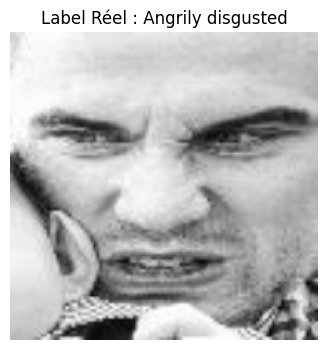

💬 Description du Vision-LLM :
➡️ 'a photograph of a face expressing emotion, detailed description of the eyes and mouth :'


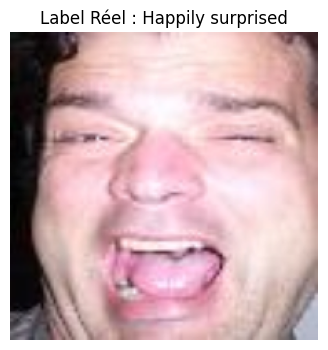

💬 Description du Vision-LLM :
➡️ 'a photograph of a face expressing emotion, detailed description of the eyes and mouth :'


In [71]:
def generate_caption(dataset, index):
    # Récupérer l'image brute
    img_tensor, label_idx = dataset[index]

    # Pour BLIP, on a besoin de l'image "Pil" (non tensorisée/normalisée)
    # Donc on la recharge proprement pour être sûr
    img_path = dataset.filenames[index]
    # On doit retrouver le chemin complet...
    # Astuce : on suppose que 'test_dataset.root_dir' est bon, sinon on bricole
    # Ici, on va faire l'inverse de la normalisation pour récupérer l'image visuelle
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    pil_image = transforms.ToPILImage()(inv_normalize(img_tensor))

    true_label = LABELS_LIST[label_idx]

    # --- PROMPT ENGINEERING VISUEL ---
    # On demande au modèle de décrire le visage et l'expression
    text_prompt = "a photograph of a face expressing emotion, detailed description of the eyes and mouth: "

    inputs = processor(pil_image, text_prompt, return_tensors="pt").to(device_llm)

    # Génération
    out = model_llm.generate(**inputs, max_new_tokens=50)
    description = processor.decode(out[0], skip_special_tokens=True)

    # Affichage
    plt.figure(figsize=(4, 4))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(f"Label Réel : {true_label}")
    plt.show()

    print(f"💬 Description du Vision-LLM :\n➡️ '{description}'")

# Test
print("Test du Vision-LLM...")
generate_caption(test_dataset, 10)
generate_caption(test_dataset, 233)

In [80]:
import re

# 1. Ton dictionnaire Wikipedia (Déjà parfait)
au_map_wikipedia = {
    '1': 'Inner brow raiser', '2': 'Outer brow raiser',
    '4': 'Brow lowerer', '5': 'Upper lid raiser', '6': 'Cheek raiser',
    '7': 'Lid tightener', '8': 'Lips toward each other', '9': 'Nose wrinkler',
    '10': 'Upper lip raiser', '11': 'Nasolabial deepener', '12': 'Lip corner puller',
    '13': 'Sharp lip puller', '14': 'Dimpler', '15': 'Lip corner depressor',
    '16': 'Lower lip depressor', '17': 'Chin raiser', '18': 'Lip pucker',
    '19': 'Tongue show', '20': 'Lip stretcher', '21': 'Neck tightener',
    '22': 'Lip funneler', '23': 'Lip tightener', '24': 'Lip pressor',
    '25': 'Lips part', '26': 'Jaw drop', '27': 'Mouth stretch', '28': 'Lip suck',
    '29': 'Jaw thrust', '43': 'Eyes closed'
}

# 2. Fonction pour nettoyer les codes (ex: "L12" -> "12")
def clean_au_code(code):
    # Enlève les lettres (L, R, T, B) et garde juste les chiffres
    return re.sub("[^0-9]", "", code)

# 3. Chargement du fichier RAFCE_AUlabel.txt
# ATTENTION : Assure-toi que le fichier est bien dans Colab
au_file_path = '/content/drive/MyDrive/Colab Datasets/RAFCE_AUlabel.txt' # Vérifie ce chemin !
# Si tu as unzippé ailleurs, adapte le chemin.

image_to_au_text = {}

try:
    with open(au_file_path, 'r') as f:
        lines = f.readlines()
        print(f"📂 Fichier AU chargé : {len(lines)} lignes trouvées.")

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 2: continue # Ligne vide ou sans label

            filename = parts[0]
            au_string = parts[1]

            # Gestion des "null"
            if "null" in au_string:
                desc = "Aucune activation musculaire détectée"
            else:
                # Séparer par '+' et nettoyer
                au_codes = au_string.split('+')
                descriptions = []
                for code in au_codes:
                    clean_code = clean_au_code(code)
                    if clean_code in au_map_wikipedia:
                        descriptions.append(au_map_wikipedia[clean_code])

                desc = ", ".join(descriptions)

            # On stocke : "0001.jpg" -> "Inner brow raiser, Lips part"
            image_to_au_text[filename] = desc

    print("✅ Mapping AU terminé ! Exemple pour 0001.jpg :")
    print(f"👉 {image_to_au_text.get('0001.jpg', 'Introuvable')}")

except FileNotFoundError:
    print(f"❌ ERREUR : Le fichier {au_file_path} est introuvable.")
    print("Vérifie où se trouve 'RAFCE_AUlabel.txt' dans tes fichiers à gauche.")

📂 Fichier AU chargé : 4549 lignes trouvées.
✅ Mapping AU terminé ! Exemple pour 0001.jpg :
👉 Inner brow raiser, Brow lowerer, Lips part


🔬 Analyse Complète :


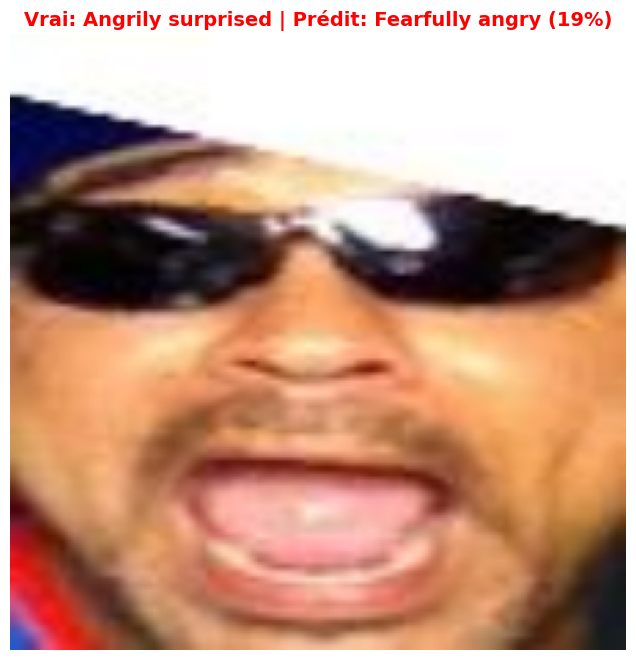

--------------------------------------------------
📄 Fichier : 0073.jpg
🧬 Anatomie (AUs réels) : 
   ➡️ Lip corner puller, Lower lip depressor, Lips part, Mouth stretch
🤖 Vision-LLM (Ce que voit l'IA) : 
   ➡️ a close - up photo of a face looking like a man with sunglasses on
--------------------------------------------------


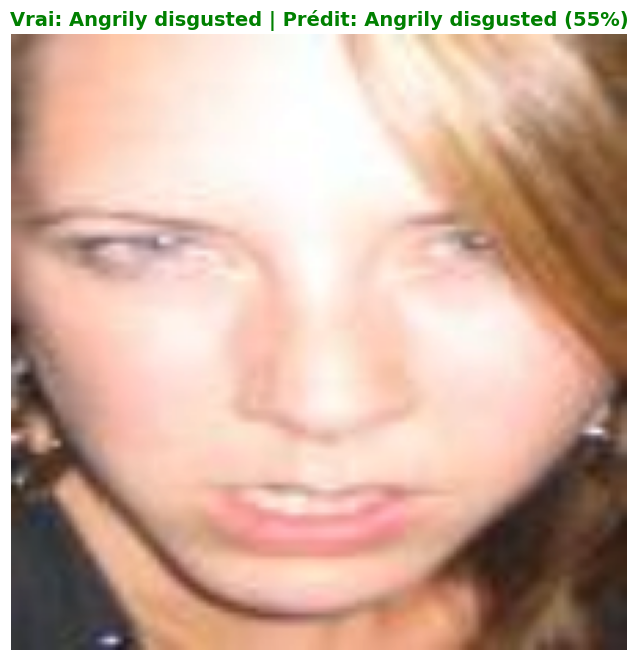

--------------------------------------------------
📄 Fichier : 0242.jpg
🧬 Anatomie (AUs réels) : 
   ➡️ Lips part
🤖 Vision-LLM (Ce que voit l'IA) : 
   ➡️ a close - up photo of a face looking at the camera
--------------------------------------------------


In [81]:
def analyze_image_full(dataset, index):
    # 1. Récupération des données
    img_tensor, label_idx = dataset[index]
    # Le nom de fichier dans le dataset est peut-être "test_0001.jpg"
    # Le fichier AU utilise "0001.jpg". On doit harmoniser.
    full_filename = dataset.filenames[index]
    simple_filename = full_filename.split('_')[-1] # Garde juste "0001.jpg"

    true_label = LABELS_LIST[label_idx]

    # Récupérer l'explication AU
    au_explanation = image_to_au_text.get(simple_filename, "Données AU non disponibles")

    # 2. Prédiction ResNet
    model.eval()
    input_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    pred_label = LABELS_LIST[pred_idx.item()]

    # 3. Vision-LLM (BLIP) - VERSION CORRIGÉE
    # On reconstruit l'image PIL
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    pil_image = transforms.ToPILImage()(inv_normalize(img_tensor))

    # ASTUCE : On donne juste le début de phrase pour le guider, mais pas trop
    inputs = processor(pil_image, "a close-up photo of a face looking", return_tensors="pt").to(device_llm)
    out = model_llm.generate(**inputs, max_new_tokens=20)
    blip_desc = processor.decode(out[0], skip_special_tokens=True)

    # 4. Affichage
    plt.figure(figsize=(8, 8))
    plt.imshow(pil_image)
    plt.axis('off')

    # Titre coloré
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Vrai: {true_label} | Prédit: {pred_label} ({conf.item()*100:.0f}%)",
              color=color, fontweight='bold', fontsize=14)

    plt.show()

    # Rapport Textuel
    print("-" * 50)
    print(f"📄 Fichier : {simple_filename}")
    print(f"🧬 Anatomie (AUs réels) : \n   ➡️ {au_explanation}")
    print(f"🤖 Vision-LLM (Ce que voit l'IA) : \n   ➡️ {blip_desc}")
    print("-" * 50)

# --- TEST ---
print("🔬 Analyse Complète :")
# Essaie quelques index différents pour trouver des images intéressantes
analyze_image_full(test_dataset, 12)
analyze_image_full(test_dataset, 45)

🔬 Test du Prompt Engineering Visuel :


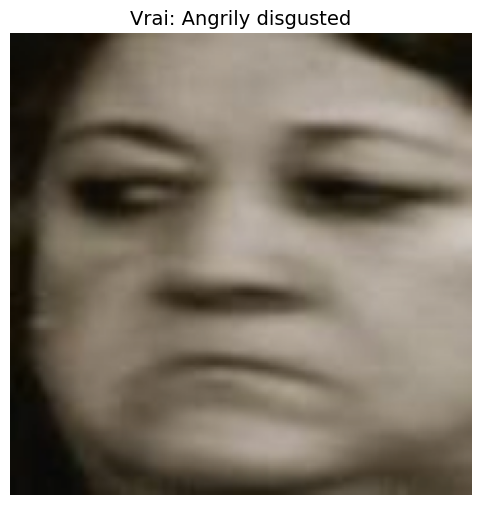

------------------------------------------------------------
📄 FICHIER : 0207.jpg
------------------------------------------------------------
🧬 VÉRITÉ ANATOMIQUE (Ground Truth AUs) :
   ➡️ Lip tightener
------------------------------------------------------------
🤖 ANALYSE VISION-LLM (Génération Conditionnelle) :
   1. Sentiment global : '... the facial expression is very visible'
   2. État de la bouche : '... the mouth is open'
   3. État des yeux     : '... the eyes are closed'
------------------------------------------------------------


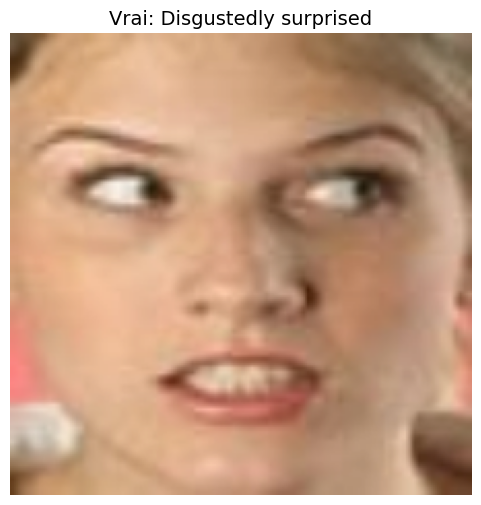

------------------------------------------------------------
📄 FICHIER : 0385.jpg
------------------------------------------------------------
🧬 VÉRITÉ ANATOMIQUE (Ground Truth AUs) :
   ➡️ Upper lid raiser, Lips part
------------------------------------------------------------
🤖 ANALYSE VISION-LLM (Génération Conditionnelle) :
   1. Sentiment global : '... the facial expression is very visible'
   2. État de la bouche : '... the mouth is open'
   3. État des yeux     : '... the eyes are open'
------------------------------------------------------------
✅ COHÉRENCE DÉTECTÉE : Le LLM a vu la bouche ouverte (validé par AU).


In [83]:
def analyze_image_focused(dataset, index):
    # 1. Récupération Image & Labels
    img_tensor, label_idx = dataset[index]

    # Gestion du nom de fichier pour les AUs
    full_filename = dataset.filenames[index]
    simple_filename = full_filename.split('_')[-1] # "0073.jpg"

    true_label = LABELS_LIST[label_idx]
    au_explanation = image_to_au_text.get(simple_filename, "Non disponible")

    # 2. Préparation Image PIL (Pour BLIP)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    pil_image = transforms.ToPILImage()(inv_normalize(img_tensor))

    # 3. INTERROGATOIRE DU VISION-LLM (Prompt Engineering)
    # On force le modèle à regarder des zones spécifiques

    # Question A: L'émotion globale
    inputs_emo = processor(pil_image, "the facial expression is", return_tensors="pt").to(device_llm)
    out_emo = model_llm.generate(**inputs_emo, max_new_tokens=10)
    desc_emo = processor.decode(out_emo[0], skip_special_tokens=True)

    # Question B: La Bouche (Pour valider les AUs comme 'Jaw Drop' ou 'Smile')
    inputs_mouth = processor(pil_image, "the mouth is", return_tensors="pt").to(device_llm)
    out_mouth = model_llm.generate(**inputs_mouth, max_new_tokens=10)
    desc_mouth = processor.decode(out_mouth[0], skip_special_tokens=True)

    # Question C: Les Yeux (Pour valider 'Brow Raiser' ou 'Eyes Closed')
    inputs_eyes = processor(pil_image, "the eyes are", return_tensors="pt").to(device_llm)
    out_eyes = model_llm.generate(**inputs_eyes, max_new_tokens=10)
    desc_eyes = processor.decode(out_eyes[0], skip_special_tokens=True)

    # 4. Affichage
    plt.figure(figsize=(6, 6))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(f"Vrai: {true_label}", color='black', fontsize=14)
    plt.show()

    # 5. Le Rapport Comparatif (Humain vs Machine)
    print("-" * 60)
    print(f"📄 FICHIER : {simple_filename}")
    print("-" * 60)
    print(f"🧬 VÉRITÉ ANATOMIQUE (Ground Truth AUs) :")
    print(f"   ➡️ {au_explanation}")
    print("-" * 60)
    print(f"🤖 ANALYSE VISION-LLM (Génération Conditionnelle) :")
    print(f"   1. Sentiment global : '... {desc_emo}'")
    print(f"   2. État de la bouche : '... {desc_mouth}'")
    print(f"   3. État des yeux     : '... {desc_eyes}'")
    print("-" * 60)

    # Petite vérification automatique de cohérence
    if "open" in desc_mouth and ("Lips part" in au_explanation or "Jaw drop" in au_explanation):
        print("✅ COHÉRENCE DÉTECTÉE : Le LLM a vu la bouche ouverte (validé par AU).")
    elif "smil" in desc_mouth and "Lip corner puller" in au_explanation:
        print("✅ COHÉRENCE DÉTECTÉE : Le LLM a vu le sourire (validé par AU).")

# --- TEST ---
print("🔬 Test du Prompt Engineering Visuel :")
# Test sur l'image 73 (celle qui échouait avant)
analyze_image_focused(test_dataset, 36)
analyze_image_focused(test_dataset, 73) # Celle avec la bouche ouverte

In [2]:
def generate_multimodal_report(dataset, index, model_resnet, model_llm, processor_llm):
    print(f"\n🔄 GÉNÉRATION DU RAPPORT POUR L'IMAGE INDEX {index}...\n")

    # --- 1. DONNÉES DE BASE ---
    img_tensor, label_idx = dataset[index]
    full_filename = dataset.filenames[index]
    simple_filename = full_filename.split('_')[-1]
    true_label_text = LABELS_LIST[label_idx]

    # Image PIL pour BLIP et Affichage
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    pil_image = transforms.ToPILImage()(inv_normalize(img_tensor))

    # --- 2. PRÉDICTION RESNET (Vision Only) ---
    model_resnet.eval()
    with torch.no_grad():
        out = model_resnet(img_tensor.unsqueeze(0).to(device))
        probs = F.softmax(out, dim=1)
        conf, pred_idx = torch.max(probs, 1)
    pred_label_text = LABELS_LIST[pred_idx.item()]

    # --- 3. EXPLICATION SCIENTIFIQUE (Ground Truth AUs) ---
    au_desc = image_to_au_text.get(simple_filename, "Non spécifié")

    # --- 4. INTERPRÉTATION VISION-LLM (Prompt Engineering) ---
    # On pose 3 questions ciblées au LLM
    prompts = {
        "Expression": "the facial expression is",
        "Yeux": "the eyes are",
        "Bouche": "the mouth is"
    }
    llm_responses = {}

    for key, prompt in prompts.items():
        inputs = processor_llm(pil_image, prompt, return_tensors="pt").to(device_llm)
        out = model_llm.generate(**inputs, max_new_tokens=15)
        llm_responses[key] = processor_llm.decode(out[0], skip_special_tokens=True)

    # --- 5. AFFICHAGE DU RAPPORT VISUEL ---
    plt.figure(figsize=(10, 6))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(pil_image)
    plt.axis('off')
    col = 'green' if true_label_text == pred_label_text else 'red'
    plt.title(f"Image: {simple_filename}\nLabel: {true_label_text}", fontsize=12)

    # Texte du rapport (Affiché comme une image pour le style)
    plt.subplot(1, 2, 2)
    plt.axis('off')

    text_report = (
        f"📊 CLASSIFICATION (ResNet)\n"
        f"---------------------------\n"
        f"Prédiction : {pred_label_text}\n"
        f"Confiance  : {conf.item()*100:.1f}%\n\n"

        f"🧬 ANATOMIE (Vérité Terrain)\n"
        f"---------------------------\n"
        f"AUs activés : {au_desc}\n\n"

        f"🤖 ANALYSE VISION-LLM\n"
        f"---------------------------\n"
        f"• {llm_responses['Expression']}\n"
        f"• {llm_responses['Yeux']}\n"
        f"• {llm_responses['Bouche']}\n"
    )
    plt.text(0, 0.2, text_report, fontsize=11, family='monospace', va='center')

    plt.tight_layout()
    plt.show()

# TEST FINAL
generate_multimodal_report(test_dataset, 73, trained_model, model_llm, processor)

NameError: name 'test_dataset' is not defined